# Build extent-clipped (tile, basin, etc) stacks
#### used to tally and report biomass within masks (zones); eg. for landcovers
after building the extent-clipped stacks, analyze with extent_report.ipynb

In [1]:
# For some reason this is needed to get s3fs to work in ExtractUtils
# this upgrades to 0.3.4 even though we already specify this version in requirements_main...
#!pip install s3fs --upgrade
#!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
import s3fs
s3 = s3fs.S3FileSystem(anon=True)

In [2]:
try:
    import geopandas as gpd
    !pip install -U plotnine
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt

import matplotlib
import geopandas as gpd
import pandas as pd
import rasterio
import glob
import os
#import rioxarray
import fiona
from pyproj import CRS, Transformer

import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils
import CovariateUtils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.plot import show_hist, show
import numpy.ma as ma
from build_stack import *

from plotnine import *
import contextily as ctx
print("Importing packages complete.")
    
font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

NASA MAAP
Importing packages complete.


## Set up output directories, covars footprint vector, and tiles vector input

In [3]:
INDIR_MAIN = '/projects/shared-buckets/nathanmthomas/analyze_agb'
# a writable outdir
OUTDIR_MAIN = '/projects/my-public-bucket/databank/boreal_height_cmip6'
!mkdir -p $OUTDIR_MAIN
OUTDIR_CLIPS = os.path.join(OUTDIR_MAIN, 'output/build_stack_basin_clips')
!mkdir -p $OUTDIR_CLIPS

# Setup access to ESA Worldcover s3 rasters
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# ESA Worldcover v100 2020
COVAR_FOOTPRINTS_FN = os.path.join(INDIR_MAIN,'footprints_v100_2020_v100_2020_map-s3.gpkg')

# Get boreal tiles to use CRS for reprojecting HYDROBASINS
boreal_tiles = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')

https://gis.stackexchange.com/questions/345917/overlay-two-raster-geotiffs-using-rasterio-mask

##### Example: Get Worldcover covariate tiles

In [4]:
# Build a VRT of the LC on s3?
covar_footprint_tiles = gpd.read_file(COVAR_FOOTPRINTS_FN)
covar_footprint_tiles.head()

,footprint_name,path,file,s3_path,geometry
0,NaN,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E006_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((9.00000 0.00000, 9.00000 3.00000, 6...."
1,NaN,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E009_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((12.00000 0.00000, 12.00000 3.00000, ..."
2,NaN,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E012_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((15.00000 0.00000, 15.00000 3.00000, ..."
3,NaN,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E015_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((18.00000 0.00000, 18.00000 3.00000, ..."
4,NaN,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E018_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((21.00000 0.00000, 21.00000 3.00000, ..."


### Establish some broad DOMAIN in which to collect regions

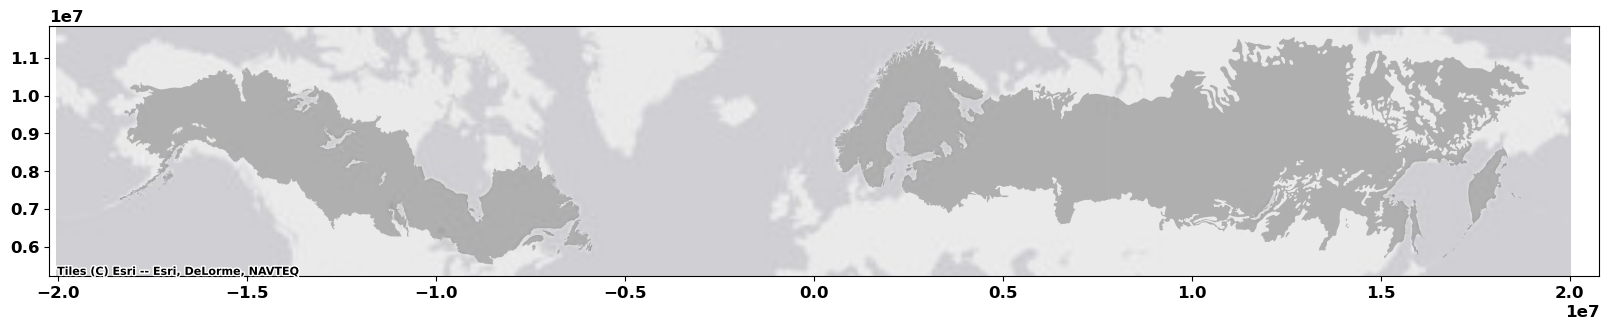

In [5]:
if False:
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
    alaska = world[world.name == 'United States of America'].explode().cx[-170:-50, 50:90]
    canada = world[world.name == 'Canada']
    canada_alaska = pd.concat([alaska, canada])
    canada_alaska.plot()
    
# Get boreal domain from wwf 
boreal_gdf = gpd.read_file('/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')
ax = boreal_gdf.to_crs(3857).plot(alpha=0.25, color='black', figsize=(20,5))
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

### Subset covariate tiles by broad domain (boreal)
* Build the spatial selector with 'intersects'
* do the subset accord to region (where region is identified with the spatial selector)

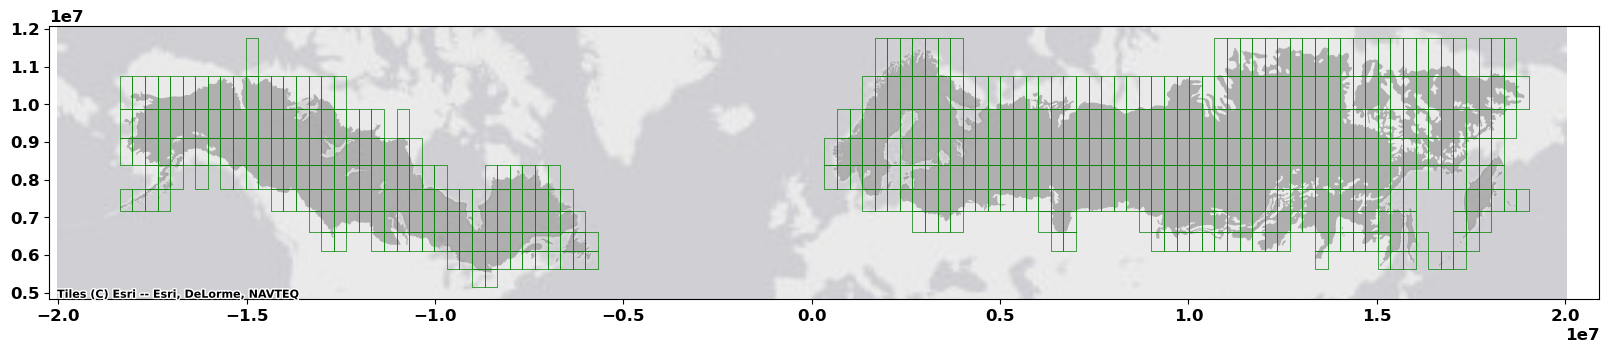

In [6]:
tile_group_region_string = 'wwf_boreal'

boreal_gdf['dissolve_field'] = 'for intersect'

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles.intersects(boreal_gdf.dissolve(by='dissolve_field').iloc[0].geometry)
covar_footprint_tiles_subset = covar_footprint_tiles[selector]
ax = covar_footprint_tiles_subset.to_crs(3857).boundary.plot(linewidth=0.5, color='green', figsize=(20,5))
ax = boreal_gdf.to_crs(3857).plot(alpha=0.25, color='black', ax=ax)
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

### Subset covariate tiles by sub-domain (eg, NA boreal)

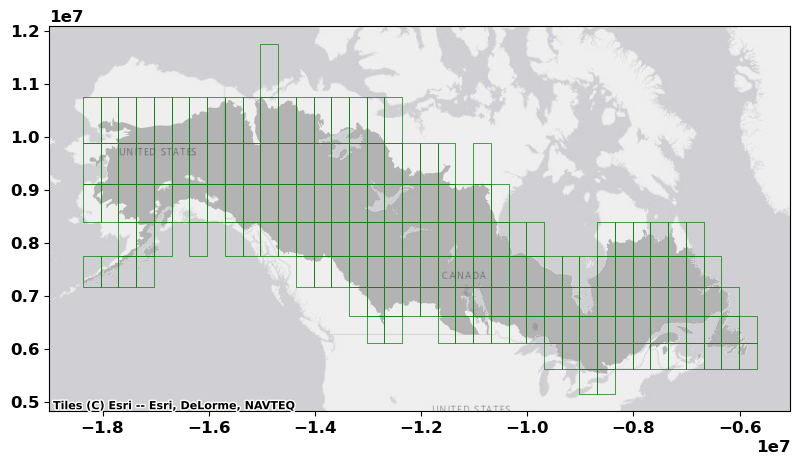

In [7]:
SUB_DOMAIN = 'america' #eurasia

tile_group_region_string = tile_group_region_string + '_' + SUB_DOMAIN

if 'america' in SUB_DOMAIN:
    xmin, xmax, ymin, ymax = [-179, -50, 30, 90]
if 'eurasia' in SUB_DOMAIN:
    xmin, xmax, ymin, ymax = [-20, 179, 30, 90]

SUB_DOMAIN_selection_geometry = boreal_gdf.cx[xmin:xmax, ymin:ymax].iloc[0].geometry

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles_subset.intersects(SUB_DOMAIN_selection_geometry)

covar_footprint_tiles_subset = covar_footprint_tiles_subset[selector]
ax = covar_footprint_tiles_subset.to_crs(3857).boundary.plot(linewidth=0.5, color='green', figsize=(20,5))
ax = boreal_gdf.cx[xmin:xmax, ymin:ymax].to_crs(3857).plot(alpha=0.25, color='black', ax=ax)
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

In [8]:
# cog bands dict
bands_dict = {'1': 'esa_worldcover_v100_2020'
             }

### Subset the hydrobasins by sub domain (eg, all basins in NA boreal) 
this is just one of many vector files you can clip by - just requires some prep

In [9]:
if False:
    # Make GPKG of a merge all hydrobasin regions for a certain level
    NORTHERN_REGION_IDS = ['ar','as','eu','na','si']
    HYBAS_LEVEL_STR = 'lev06'
    OUT_HYBAS_NORTHERN_FN = os.path.join(OUTDIR_MAIN, 'input_zones', f'hybas_lake_NORTHERN_{HYBAS_LEVEL_STR}_{SUB_DOMAIN}_vc1.gpkg')

    if not os.path.isfile(OUT_HYBAS_NORTHERN_FN):
        print(f"Building and writing file: {OUT_HYBAS_NORTHERN_FN}")
        pd.concat([gpd.read_file(f).cx[xmin:xmax, ymin:ymax] for f in [glob.glob(f'/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_{hybas_reg}_{HYBAS_LEVEL_STR}_v1c.shp')[0] for hybas_reg in NORTHERN_REGION_IDS]]).to_file(OUT_HYBAS_NORTHERN_FN, driver='GPKG')
       # pd.concat([gpd.read_file(f) for f in glob.glob(f'/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_*_{HYBAS_LEVEL_STR}_v1c.shp')]).to_file(OUT_HYBAS_GLOBAL_FN, driver='GPKG')
    print(f"{OUT_HYBAS_NORTHERN_FN}")

In [10]:
OUT_HYBAS_NORTHERN_FN = '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra.gpkg'
OUT_HYBAS_NORTHERN_FN
tile_group_region_string = 'tte_boreal_tundra'
HYBAS_LEVEL_STR = 'hydrobasins_L08_patterns_tte_boreal_tundra'

In [11]:
import fiona
fiona.listlayers(OUT_HYBAS_NORTHERN_FN)

['hydrobasins_L08_patterns_tte_boreal_tundra']

In [12]:
z = gpd.read_file(OUT_HYBAS_NORTHERN_FN)
z.head()

,HYBAS_ID,pattern_class,geometry
0,8080000061,TTE (diffuse),"MULTIPOLYGON (((-138.23069 59.25043, -138.2324..."
1,8080000062,TTE (diffuse),"MULTIPOLYGON (((-137.79244 59.46382, -137.7934..."
2,8080300321,TTE (diffuse),"POLYGON ((-137.71532 59.46324, -137.71076 59.4..."
3,8080300322,TTE (diffuse),"POLYGON ((-137.74692 59.48233, -137.74409 59.4..."
4,8080300251,TTE (diffuse),"POLYGON ((-137.74958 59.49834, -137.74619 59.5..."


### Establish and CHOOSE the clip INDEX_FN
vector polygon regions (specific basin, LVIS flightline, tile, etc within sub-domain)
* the GPKG that holds 1 specific clip polygon

In [13]:
CLIP_INDEX_DICT_LIST = [
    # Hydrobasins
    {
        'ID_COL_NAME': 'HYBAS_ID',
        'ID': None,#7060157640, #3060534340, #7060157640 4070084980 #4070000010,
        'ID_NAME': HYBAS_LEVEL_STR,
        'INDEX_LYR': None,
        'INDEX_FN': OUT_HYBAS_NORTHERN_FN, #f'/projects/my-public-bucket/analyze_agb/hydrobasins/{HYBAS_FILE}.shp'
        'ADD_STR': "-" + tile_group_region_string + '-reprj',
        'INDEX_REPRJ_FN': OUT_HYBAS_NORTHERN_FN.replace('.gpkg', "-" + tile_group_region_string + '-reprj' + '.gpkg')
    }
]

# Choose SPECIFIC dictionary with clip index vector (AOI) info

In [14]:
CLIP_INDEX_DICT = CLIP_INDEX_DICT_LIST[0]
CLIP_INDEX_DICT

{'ID_COL_NAME': 'HYBAS_ID',
 'ID': None,
 'ID_NAME': 'hydrobasins_L08_patterns_tte_boreal_tundra',
 'INDEX_LYR': None,
 'INDEX_FN': '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra.gpkg',
 'ADD_STR': '-tte_boreal_tundra-reprj',
 'INDEX_REPRJ_FN': '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj.gpkg'}

### Read and subset the clipping INDEX vector
update string variables used in BUILD_STACK

In [15]:
CLIP_INDEX_DICT

{'ID_COL_NAME': 'HYBAS_ID',
 'ID': None,
 'ID_NAME': 'hydrobasins_L08_patterns_tte_boreal_tundra',
 'INDEX_LYR': None,
 'INDEX_FN': '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra.gpkg',
 'ADD_STR': '-tte_boreal_tundra-reprj',
 'INDEX_REPRJ_FN': '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj.gpkg'}

In [16]:
INPUT_CRS_UNITS = z.crs.axis_info[0].unit_name

if 'degree' in INPUT_CRS_UNITS:

    print('Reprojecting to equal area and writing reprojected output...')
    # Reproject hydrobasin SELECTION to equal area (boreal_tiles)
    z.to_crs(boreal_tiles.crs).to_file(CLIP_INDEX_DICT['INDEX_REPRJ_FN'], driver='GPKG', layer=CLIP_INDEX_DICT['INDEX_LYR'])

    # Read and plot the basin in orig prj
    #z = gpd.read_file(INDEX_FN).to_crs(4326)

    # Now change this variable back to what BUILD_STACK_DICT wants
    # Now you have INDEX_FN in the boreal_tiles crs
    INDEX_FN = CLIP_INDEX_DICT['INDEX_REPRJ_FN']
else:
    INDEX_FN = CLIP_INDEX_DICT['INDEX_FN']


# The INDEX_LYR comes off the INDEX_FN set just above...
if CLIP_INDEX_DICT['INDEX_LYR'] is None:
    print('Specify the layer name of the GPKG...')
    INDEX_LYR = os.path.split(INDEX_FN)[1].split('.gpkg')[0]
else:
    INDEX_LYR = CLIP_INDEX_DICT['INDEX_LYR']

print(f"\nDone updating file string input for build_stack():\n{INDEX_FN}\n{INDEX_LYR}")

Reprojecting to equal area and writing reprojected output...
Specify the layer name of the GPKG...

Done updating file string input for build_stack():
/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj.gpkg
hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj


### Get clip extent: randomly choose a feature (polygon) to examine and plot

Variables needed for input into BUILD_CLIP_DICT:


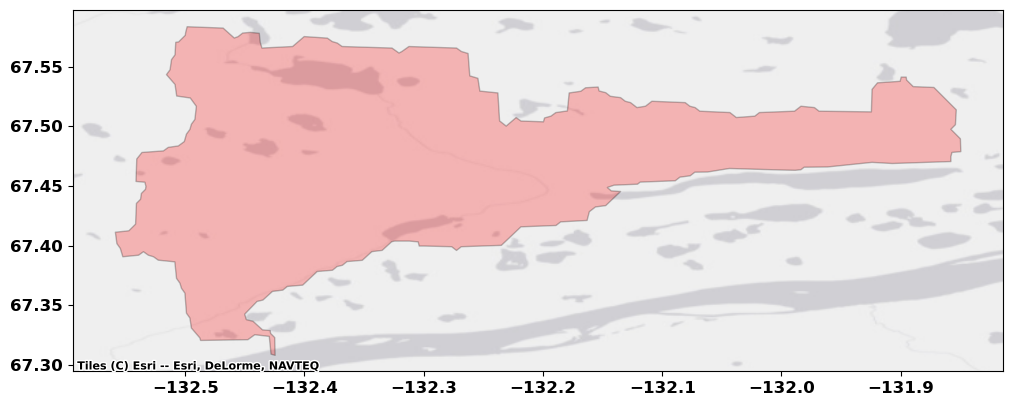

In [17]:
if CLIP_INDEX_DICT['ID'] is None:
    # Get random feature (HYBAS)
    TILE_NUM = z.sample(n=1)[CLIP_INDEX_DICT['ID_COL_NAME']].to_list()[0]
else:
    TILE_NUM = CLIP_INDEX_DICT['ID']
    

print('Variables needed for input into BUILD_CLIP_DICT:')
ID_COL_NAME = CLIP_INDEX_DICT['ID_COL_NAME']
# print(INDEX_FN)
# print(INDEX_LYR)
# print(ID_COL_NAME)
# print(TILE_NUM)

# Some extents will be near the -180 line and cause the plotting chunk to fail when doing the area calc.
# Try removing these polygons.
ax = z[ z[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM  ].plot(color='red', alpha=0.25, ec='k', figsize=(12,8))
ax = ctx.add_basemap(ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, zoom=10)
BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004]

#### Plot clip extent within boreal 
This will fail if the TILE_NUM specified is NOT in the data frame

# Set list of dictionary inputs to stack
## Setup input using hydrobasin as clip INDEX_FN
* reprojected to equal area using boreal_tile_index
* so output has same res, crs, and clip extent

In [18]:
#BUILD_STACK_DICT = {'INDEX_FN':INDEX_FN,'ID_COL_NAME':ID_COL_NAME,'TILE_NUM':TILE_NUM,'INDEX_LYR':INDEX_LYR,'RASTER_NAME':'','COVAR_TILE_FN':'', 'IN_COVAR_S3_COL':'', 'NODATA_VAL':''}
DEFAULT_BUILD_STACK_DICT_LIST = [
    # # ESA Worldcover 2020
    #     {
    #         'INDEX_FN':INDEX_FN,
    #         'ID_COL_NAME':ID_COL_NAME,
    #         'TILE_NUM':TILE_NUM,
    #         'INDEX_LYR':INDEX_LYR,
    #         # Worldcover data is accessed via its footprint, with a 's3_path' col identifying the s3 locations of each tile
    #         'RASTER_NAME': 'esa_worldcover_v100_2020',
    #         'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints_v100_2020_v100_2020_map-s3.gpkg',
    #         'IN_COVAR_S3_COL': 's3_path',
    #         'NODATA_VAL': 0,
    #         'OUTPUT_CLIP_COG_FN':'',
    #         'CREDENTIALS_FN': None
    #     },
        # # Boreal Biomass c2020 (final)
        # {
        #     'INDEX_FN':INDEX_FN,
        #     'ID_COL_NAME':ID_COL_NAME,
        #     'TILE_NUM':TILE_NUM,
        #     'INDEX_LYR':INDEX_LYR,
        #     # AGB data is accessed
        #     # This needs to be correctly in 4326 - 
        #     'RASTER_NAME': 'biomass_final',
        #     'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.json',
        #     'IN_COVAR_S3_COL': 's3_path',
        #     'NODATA_VAL': -9999,
        #     'OUTPUT_CLIP_COG_FN':'',
        #     'CREDENTIALS_FN': None
        # },
    # # Boreal Stand Age 2020
    #     {
    #         'INDEX_FN':INDEX_FN,
    #         'ID_COL_NAME':ID_COL_NAME,
    #         'TILE_NUM':TILE_NUM,
    #         'INDEX_LYR':INDEX_LYR,
    #         # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
    #         'RASTER_NAME': 'standage',
    #         'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints_terrapulse-pub-data_forest_age_v2-s3.gpkg',
    #         'IN_COVAR_S3_COL': 's3_path',
    #         'NODATA_VAL': 255,
    #         'OUTPUT_CLIP_COG_FN':'',
    #         'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
    #     },
    # Boreal TCC 2020
        # {
        #     'INDEX_FN':INDEX_FN,
        #     'ID_COL_NAME':ID_COL_NAME,
        #     'TILE_NUM':TILE_NUM,
        #     'INDEX_LYR':INDEX_LYR,
        #     # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
        #     'RASTER_NAME': 'tcc2020',
        #     'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints_terrapulse-pub-data_tcc_2020-s3.gpkg',
        #     'IN_COVAR_S3_COL': 's3_path',
        #     'NODATA_VAL': 255,
        #     'OUTPUT_CLIP_COG_FN':'',
        #     'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        # },
    # Boreal TCC rate of change (linear), 1984-2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'tccslope',
            'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints_terrapulse-pub-data_tcc_slope-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        },
    # Boreal TCC rate of change (linear) p-value, 1984-2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'tccpvalue',
            'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints_terrapulse-pub-data_tcc_pvalue-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        }
]

DEFAULT_BUILD_STACK_DICT_LIST

[{'INDEX_FN': '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj.gpkg',
  'ID_COL_NAME': 'HYBAS_ID',
  'TILE_NUM': 8080125372,
  'INDEX_LYR': 'hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj',
  'RASTER_NAME': 'tccslope',
  'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/analyze_agb/footprints_terrapulse-pub-data_tcc_slope-s3.gpkg',
  'IN_COVAR_S3_COL': 's3_path',
  'NODATA_VAL': 255,
  'OUTPUT_CLIP_COG_FN': '',
  'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'},
 {'INDEX_FN': '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj.gpkg',
  'ID_COL_NAME': 'HYBAS_ID',
  'TILE_NUM': 8080125372,
  'INDEX_LYR': 'hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj',
  'RASTER_NAME': 'tccpvalue',
  'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/analyze_agb/footprints_terrapulse-pub-da

# Choose layers for stack

In [19]:
BUILD_STACK_DICT_LIST = DEFAULT_BUILD_STACK_DICT_LIST
BUILD_STACK_DICT_LIST

[{'INDEX_FN': '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj.gpkg',
  'ID_COL_NAME': 'HYBAS_ID',
  'TILE_NUM': 8080125372,
  'INDEX_LYR': 'hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj',
  'RASTER_NAME': 'tccslope',
  'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/analyze_agb/footprints_terrapulse-pub-data_tcc_slope-s3.gpkg',
  'IN_COVAR_S3_COL': 's3_path',
  'NODATA_VAL': 255,
  'OUTPUT_CLIP_COG_FN': '',
  'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'},
 {'INDEX_FN': '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj.gpkg',
  'ID_COL_NAME': 'HYBAS_ID',
  'TILE_NUM': 8080125372,
  'INDEX_LYR': 'hydrobasins_L08_patterns_tte_boreal_tundra-tte_boreal_tundra-reprj',
  'RASTER_NAME': 'tccpvalue',
  'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/analyze_agb/footprints_terrapulse-pub-da

## Run the extent clips of the rasters
#### Get the list of IDs

In [21]:
TTE_HYBAS_FN = '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte.gpkg'
TTE_HYBAS_FN = '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra.gpkg'
hybas_L08_boreal_tte_tundra = gpd.read_file(TTE_HYBAS_FN ).to_crs(3995) #OUT_HYBAS_NORTHERN_FN
HYBAS_ID_LIST = hybas_L08_boreal_tte_tundra.HYBAS_ID.to_list()

In [22]:
hybas_L08_boreal_tte_tundra['area_sqkm'] = hybas_L08_boreal_tte_tundra.geometry.area / 1e6

In [23]:
# z = hybas_L08_boreal_tte_tundra[hybas_L08_boreal_tte_tundra.area_sqkm < 0.01]
# #hybas_L08_boreal_tte_tundra[hybas_L08_boreal_tte_tundra.HYBAS_ID == '7080026381'].head()#.plot()
# ax = z.head(1).centroid.plot(markersize=1, color='red')
# #hybas_L08_boreal_tte_tundra[hybas_L08_boreal_tte_tundra.HYBAS_ID == '7080019440'].plot(column='pattern_class', alpha=0.1, ax=ax, ec='black')
hybas_L08_boreal_tte_tundra.head()

,HYBAS_ID,pattern_class,geometry,area_sqkm
0,8080000061,TTE (diffuse),"MULTIPOLYGON (((-2278406.218 2551007.150, -227...",949.476605
1,8080000062,TTE (diffuse),"MULTIPOLYGON (((-2281151.732 2515092.441, -228...",1155.140237
2,8080300321,TTE (diffuse),"POLYGON ((-2284580.186 2512070.223, -2285136.9...",11.084951
3,8080300322,TTE (diffuse),"POLYGON ((-2281700.076 2511684.476, -2282043.8...",1.795264
4,8080300251,TTE (diffuse),"POLYGON ((-2280330.161 2510410.788, -2280212.3...",119.300911


In [ ]:
df_smry = hybas_L08_boreal_tte_tundra.groupby(['HYBAS_ID']).aggregate({'pattern_class':'count',  'area_sqkm':'min'}).reset_index()
dup_id_list = df_smry[df_smry.pattern_class > 1].HYBAS_ID.to_list()
dup_id_list_mins_gt1 = df_smry[df_smry.pattern_class > 1][df_smry.area_sqkm > 1].HYBAS_ID.to_list()
hybas_L08_boreal_tte_tundra[hybas_L08_boreal_tte_tundra.HYBAS_ID.isin(dup_id_list_mins_gt1)].dropna().explore(column='pattern_class')

In [24]:
from multiprocessing import Pool
from functools import partial

In [26]:
def multi_process_build_stack(ID, BUILD_STACK_DICT=BUILD_STACK_DICT_LIST[0], OUTDIR_CLIPS=OUTDIR_CLIPS):
    
    BUILD_STACK_DICT.update([('TILE_NUM', ID)])
    BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN'] = os.path.join( OUTDIR_CLIPS, f"{BUILD_STACK_DICT['RASTER_NAME']}_{BUILD_STACK_DICT['TILE_NUM']}_cog.tif")
    
    # # INDEX clip shapes should be in equal area
    # # COVAR_TILE_FN tiles (of raster COGs) should be in 4326
    # args = f"\
    # --in_tile_fn {BUILD_STACK_DICT['INDEX_FN']} \
    # --in_tile_id_col {BUILD_STACK_DICT['ID_COL_NAME']} \
    # --in_tile_num {BUILD_STACK_DICT['TILE_NUM']} \
    # --tile_buffer_m 0 \
    # --in_tile_layer {BUILD_STACK_DICT['INDEX_LYR']} \
    # -o {OUTDIR_CLIPS} \
    # --topo_off \
    # --covar_src_name {BUILD_STACK_DICT['RASTER_NAME']} \
    # --covar_tile_fn {BUILD_STACK_DICT['COVAR_TILE_FN']} \
    # --in_covar_s3_col {BUILD_STACK_DICT['IN_COVAR_S3_COL']} \
    # --input_nodata_value {BUILD_STACK_DICT['NODATA_VAL']} \
    # --clip" #<-- testing a clip to polygon
    # print(args,'\n')
    
    def run_build_stack():
        build_stack_(
            stack_tile_fn = BUILD_STACK_DICT['INDEX_FN'], 
            in_tile_id_col = BUILD_STACK_DICT['ID_COL_NAME'], 
            stack_tile_id = BUILD_STACK_DICT['TILE_NUM'],
            tile_buffer_m = 0, 
            stack_tile_layer = BUILD_STACK_DICT['INDEX_LYR'],
            covar_tile_fn = BUILD_STACK_DICT['COVAR_TILE_FN'],
            in_covar_s3_col = BUILD_STACK_DICT['IN_COVAR_S3_COL'], 
            res = 30, 
            input_nodata_value = BUILD_STACK_DICT['NODATA_VAL'],
            tmp_out_path = '/projects/tmp', 
            covar_src_name = BUILD_STACK_DICT['RASTER_NAME'],
            clip = True, 
            topo_off = True, 
            output_dir = OUTDIR_CLIPS,
            height = None,
            width = None
           )
    if True:
        # Try without setting up an aws_session
        run_build_stack()
    else:
        if BUILD_STACK_DICT['CREDENTIALS_FN'] is not None:
            aws_session = CovariateUtils.get_rio_aws_session_from_creds(BUILD_STACK_DICT['CREDENTIALS_FN'])
            with rio.Env(aws_session):
                #!python /projects/Developer/icesat2_boreal/lib/build_stack.py $args
                run_build_stack()
        else:
            #!python /projects/Developer/icesat2_boreal/lib/build_stack.py $args
            run_build_stack()

In [71]:
with Pool(processes=4) as pool:
    returned_stuff = pool.map(partial(multi_process_build_stack, BUILD_STACK_DICT = BUILD_STACK_DICT_LIST[0], OUTDIR_CLIPS = OUTDIR_CLIPS ), ['8080279620', '8080285990', '8080276800', '8080269420'])

The covariate's filename(s) intersecting the 0 m buffered bbox for tile id 8080269420:
 s3://terrapulse-pub-data/boreal-forest-data/tcc_slope/data/128W/62N/128W_62N/128W_62N_tcc_slope.tif
in_bbox: [2583442.216154301, 3451044.10304374, 2604188.9296123264, 3469459.3287899126]
Getting output height and width from buffered (buffer=0) original tile geometry...
613 x 691


/opt/conda/lib/python3.10/site-packages/rio_tiler/io/rasterio.py:117: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.


The covariate's filename(s) intersecting the 0 m buffered bbox for tile id 8080276800:
 s3://terrapulse-pub-data/boreal-forest-data/tcc_slope/data/130W/62N/130W_62N/130W_62N_tcc_slope.tif
in_bbox: [2482044.1555501875, 3335748.760319371, 2534952.7776202206, 3382727.897042014]
Getting output height and width from buffered (buffer=0) original tile geometry...
1565 x 1763
The covariate's filename(s) intersecting the 0 m buffered bbox for tile id 8080285990:
 s3://terrapulse-pub-data/boreal-forest-data/tcc_slope/data/130W/62N/130W_62N/130W_62N_tcc_slope.tif
in_bbox: [2455137.0436412124, 3247476.4627098697, 2518863.6910373624, 3331135.121699648]
Getting output height and width from buffered (buffer=0) original tile geometry...
2788 x 2124


/opt/conda/lib/python3.10/site-packages/rio_tiler/io/rasterio.py:117: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
/opt/conda/lib/python3.10/site-packages/rio_tiler/io/rasterio.py:117: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.


The covariate's filename(s) intersecting the 0 m buffered bbox for tile id 8080279620:
 s3://terrapulse-pub-data/boreal-forest-data/tcc_slope/data/130W/62N/130W_62N/130W_62N_tcc_slope.tif
in_bbox: [2478667.038681748, 3279033.701552247, 2531084.699712579, 3334488.5962465047]
Getting output height and width from buffered (buffer=0) original tile geometry...
1848 x 1747


/opt/conda/lib/python3.10/site-packages/rio_tiler/io/rasterio.py:117: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.


Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080269420_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 613, 691)
Output resolution:		 (30, 30)
Writing img to memory...


/projects/code/icesat2_boreal/lib/build_stack.py:152: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.


{'driver': 'VRT', 'dtype': 'float32', 'nodata': 255, 'width': 692, 'height': 614, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 2583442.216154301,
       0.0, -30.0, 3469459.3287899126), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}


Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/65bcb91b-476f-410c-9e78-06e8f46e209b/65bcb91b-476f-410c-9e78-06e8f46e209b.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080269420_cog.tif


Image written to disk:		 /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080269420_cog.tif
Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080276800_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 1565, 1763)
Output resolution:		 (30, 30)
Writing img to memory...


/projects/code/icesat2_boreal/lib/build_stack.py:152: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.


{'driver': 'VRT', 'dtype': 'float32', 'nodata': 255, 'width': 1764, 'height': 1566, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 2482044.1555501875,
       0.0, -30.0, 3382727.897042014), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}


Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/c3384526-2fb6-41f3-b567-859b8199b9d6/c3384526-2fb6-41f3-b567-859b8199b9d6.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080276800_cog.tif


Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080279620_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 1848, 1747)
Output resolution:		 (30, 30)
Writing img to memory...


/projects/code/icesat2_boreal/lib/build_stack.py:152: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.


{'driver': 'VRT', 'dtype': 'float32', 'nodata': 255, 'width': 1748, 'height': 1849, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 2478667.038681748,
       0.0, -30.0, 3334488.5962465047), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}


Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/d8f8eb31-f9f4-4afe-ad87-cebc349339cd/d8f8eb31-f9f4-4afe-ad87-cebc349339cd.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080279620_cog.tif


Image written to disk:		 /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080276800_cog.tif
Image written to disk:		 /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080279620_cog.tif
Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080285990_cog.tif
Clipping to feature polygon...
Orig stack shape:		 (1, 2788, 2124)
Output resolution:		 (30, 30)
Writing img to memory...


/projects/code/icesat2_boreal/lib/build_stack.py:152: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.


{'driver': 'VRT', 'dtype': 'float32', 'nodata': 255, 'width': 2125, 'height': 2789, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 2455137.0436412124,
       0.0, -30.0, 3331135.121699648), 'blockxsize': 512, 'blockysize': 128, 'tiled': True}


Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/4b13d149-62ba-4acd-9283-f5cc95113284/4b13d149-62ba-4acd-9283-f5cc95113284.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080285990_cog.tif


Image written to disk:		 /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccslope_8080285990_cog.tif


In [76]:
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 2.6 MB/s eta 0:00:00a 0:00:01


In [95]:
def rename_columns(GDF, bandname, stats_list):
    if stats_list is not None:
       
        names_list = ['val_'+ bandname + '_' + s for s in stats_list]
        rename_dict = dict(zip(stats_list, names_list))      
        GDF = GDF.rename(columns = rename_dict)
        
    return GDF

def extract_zonal_gdf_poly(HYBAS_ID, bandnames: list, GDF_fn = OUT_HYBAS_NORTHERN_FN, ndval=255, 
                           stats_list = ['max','min','median','mean','percentile_02','percentile_25','percentile_75','percentile_98','count']):
    
    r_fn = f'/projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccpvalue_{HYBAS_ID}_cog.tif'
    GDF = gpd.read_file(GDF_fn)
    GDF = GDF[GDF.HYBAS_ID == HYBAS_ID]
    
    from rasterstats import zonal_stats
    import numpy as np
    
    gdf_list = []
    
    with rasterio.open(r_fn) as r_src:
        print("\tExtracting raster values from: ", r_fn)

        for i, bandname in enumerate(bandnames):
            
            bnum = i + 1
            print(bnum)
            
            # Get array
            array = r_src.read(bnum)
            array = array.astype('float64')
            array[array==ndval] = np.nan
            df = pd.DataFrame(
                    zonal_stats(
                        vectors=GDF.to_crs(r_src.crs), 
                        raster= array,#r_src.read(bnum, masked=True),
                        affine= r_src.transform,
                        stats=stats_list
                    )
            )

            # Rename cols
            df = rename_columns(df, bandname, stats_list)

            final_gdf = GDF.reset_index().join(df.reset_index(drop=True), how='left')
            gdf_list.append(final_gdf)
            
        # Write the table of zonal stats on each band for current HYBAS_ID   
        hybas_id_gdf = pd.concat(gdf_list)
        hybas_id_gdf.to_file(r_fn.split('.tif')[0] + '_zonalstats.gpkg', driver = 'GPKG')
    
    return pd.concat(gdf_list)

# z = extract_zonal_gdf_poly(r_fn, GDF[GDF.HYBAS_ID == HYBAS_ID].iloc[[0]], bandnames=['tcc_slope'], reproject=False)
# z

In [97]:
with Pool(processes=4) as pool:
    returned_stuff = pool.map(partial(extract_zonal_gdf_poly, bandnames = ['tccslope'], GDF_fn = OUT_HYBAS_NORTHERN_FN ), ['8080279620', '8080285990', '8080276800', '8080269420'])

	Extracting raster values from:  /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccpvalue_8080285990_cog.tif
1


/opt/conda/lib/python3.10/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly


	Extracting raster values from: 	Extracting raster values from:   /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccpvalue_8080279620_cog.tif/projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccpvalue_8080269420_cog.tif

11



/opt/conda/lib/python3.10/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
/opt/conda/lib/python3.10/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly


	Extracting raster values from:  /projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccpvalue_8080276800_cog.tif
1


/opt/conda/lib/python3.10/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly


In [98]:
pd.concat(returned_stuff)

,index,HYBAS_ID,pattern_class,geometry,val_tccslope_min,val_tccslope_max,val_tccslope_mean,val_tccslope_count,val_tccslope_median,val_tccslope_percentile_02,val_tccslope_percentile_25,val_tccslope_percentile_75,val_tccslope_percentile_98
0,2201,8080279620,TTE diffuse,"POLYGON ((-128.88506 60.80869, -128.86284 60.8...",1.036452e-28,1.000000,0.405231,1478880,1.386249e-01,7.978080e-12,3.275628e-04,1.000000e+00,1.000000
1,12634,8080279620,boreal,"MULTIPOLYGON (((-128.19388 60.59527, -128.2019...",1.179616e-06,1.000000,0.259238,18,1.194037e-01,1.253070e-06,3.055857e-02,2.366298e-01,1.000000
0,2202,8080285990,TTE diffuse,"POLYGON ((-129.42918 60.62915, -129.42693 60.6...",2.800274e-26,1.000000,0.412777,2385876,1.387852e-01,2.849146e-11,1.106067e-03,1.000000e+00,1.000000
1,12621,8080285990,boreal,"MULTIPOLYGON (((-128.75000 60.42500, -128.7492...",6.961336e-13,1.000000,0.436482,32,2.517003e-01,3.025609e-11,3.540624e-05,1.000000e+00,1.000000
0,2203,8080276800,TTE diffuse,"POLYGON ((-128.12882 61.11075, -128.12536 61.1...",2.452631e-26,1.000000,0.297070,1037711,6.632142e-02,2.866466e-09,1.756197e-03,5.746593e-01,1.000000
1,12542,8080276800,boreal,"MULTIPOLYGON (((-127.69223 60.74779, -127.6922...",1.064217e-06,0.231149,0.057845,4,1.156741e-04,1.119720e-06,1.758004e-06,5.795915e-02,0.217293
0,2204,8080269420,TTE diffuse,"POLYGON ((-125.47563 61.13117, -125.47500 61.1...",1.072597e-29,1.000000,0.023193,195720,2.905809e-11,7.872767e-21,2.045506e-14,7.265951e-08,0.522382
1,11768,8080269420,boreal,"MULTIPOLYGON (((-125.20417 61.10000, -125.2041...",3.942438e-07,1.000000,0.252414,4,4.826999e-03,4.765719e-06,5.503769e-05,2.571856e-01,0.940575


In [40]:
# For each clip INDEX (polygon) there are 2 corresponding output clipped COGs you need
BASIN_COG_DICT = {'landcover_cog_fn': '', 'biomass_cog_fn':'', 'standage_cog_fn':'', 'extent_gdf_fn': extent_gdf_fn}

for BUILD_STACK_DICT in BUILD_STACK_DICT_LIST:
    if 'worldcover' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'landcover_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'biomass' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'biomass_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'standage' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'standage_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'tcc2020' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'tcc2020_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'tccslope' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'tccslope_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'tccpvalue' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'tccpvalue_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
BASIN_COG_DICT

NameError: name 'extent_gdf_fn' is not defined